# TabM

This is a standalone usage example for the TabM project.
The easiest way to run it is [Pixi](https://pixi.sh/latest/#installation):

```shell
git clone https://github.com/yandex-research/tabm
cd tabm

# With GPU:
pixi run -e cuda jupyter-lab example.ipynb

# Without GPU:
pixi run jupyter-lab example.ipynb
```

For the full overview of the project, and for non-Pixi environment setups, see README in the repository:
https://github.com/yandex-research/tabm

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import random
from tabm_reference import Model, make_parameter_groups
import torch.nn as nn
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score

random.seed ( 12 )


df = pd.read_csv('diabetes.csv')
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# torch tensor
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [17]:

# TabM 
tabm_model = Model(
    n_num_features=8,
    cat_cardinalities=[],
    n_classes=2,
    backbone={'type':'MLP','n_blocks':2,'d_block':64,'dropout':0.1},
    bins=None,
    arch_type='tabm',
    k=8,
)

# TabM-mini 
tabm_mini_model = Model(
    n_num_features=8,
    cat_cardinalities=[],
    n_classes=2,
    backbone={'type':'MLP','n_blocks':2,'d_block':64,'dropout':0.1},
    bins=None,
    arch_type='tabm-mini',
    k=8,
)

# MLP
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(8,64), nn.ReLU(), nn.Linear(64,2))
        
    def forward(self,x):
        return self.model(x)

mlp_model = SimpleMLP()

# XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss')


In [18]:
def train_model(model, loader, epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in loader:
            preds = model(X_batch).mean(dim=1) if isinstance(model, Model) else model(X_batch)
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}")



In [19]:
print("Training TabM:")
train_model(tabm_model, train_loader)

print("\nTraining TabM-mini:")
train_model(tabm_mini_model, train_loader)

print("\nTraining MLP:")
train_model(mlp_model, train_loader)

print("\nTraining XGBoost:")
xgb_model.fit(X_train, y_train)



Training TabM:
Epoch [1/30] - Loss: 12.9480
Epoch [2/30] - Loss: 11.6151
Epoch [3/30] - Loss: 10.3163
Epoch [4/30] - Loss: 9.5727
Epoch [5/30] - Loss: 9.4879
Epoch [6/30] - Loss: 9.3146
Epoch [7/30] - Loss: 8.9437
Epoch [8/30] - Loss: 8.9472
Epoch [9/30] - Loss: 9.2505
Epoch [10/30] - Loss: 9.1694
Epoch [11/30] - Loss: 8.8003
Epoch [12/30] - Loss: 8.5752
Epoch [13/30] - Loss: 8.6043
Epoch [14/30] - Loss: 9.2029
Epoch [15/30] - Loss: 8.5955
Epoch [16/30] - Loss: 8.6603
Epoch [17/30] - Loss: 8.4271
Epoch [18/30] - Loss: 8.8911
Epoch [19/30] - Loss: 8.8977
Epoch [20/30] - Loss: 8.3153
Epoch [21/30] - Loss: 8.3950
Epoch [22/30] - Loss: 8.5850
Epoch [23/30] - Loss: 8.4158
Epoch [24/30] - Loss: 8.3453
Epoch [25/30] - Loss: 8.2037
Epoch [26/30] - Loss: 8.3466
Epoch [27/30] - Loss: 8.4628
Epoch [28/30] - Loss: 8.1038
Epoch [29/30] - Loss: 8.2482
Epoch [30/30] - Loss: 8.4277

Training TabM-mini:
Epoch [1/30] - Loss: 13.2699
Epoch [2/30] - Loss: 11.8966
Epoch [3/30] - Loss: 10.6824
Epoch [4/30] 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
def evaluate_model(model, loader):
    model.eval()
    preds_list, true_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            preds = model(X_batch).mean(dim=1) if isinstance(model, Model) else model(X_batch)
            probs = torch.softmax(preds, dim=1)[:,1]
            preds_list.extend(probs.numpy())
            true_labels.extend(y_batch.numpy())
    acc = accuracy_score(true_labels, np.array(preds_list)>0.5)
    auc_score = roc_auc_score(true_labels, preds_list)
    return acc, auc_score, preds_list


In [21]:

tabm_acc, tabm_auc, tabm_probs = evaluate_model(tabm_model, test_loader)
mini_acc, mini_auc, mini_probs = evaluate_model(tabm_mini_model, test_loader)
mlp_acc, mlp_auc, mlp_probs = evaluate_model(mlp_model, test_loader)
xgb_probs = xgb_model.predict_proba(X_test)[:,1]
xgb_acc = accuracy_score(y_test, xgb_probs>0.5)
xgb_auc = roc_auc_score(y_test, xgb_probs)

print(f"TabM Accuracy: {tabm_acc:.4f}, AUC: {tabm_auc:.4f}")
print(f"TabM-mini Accuracy: {mini_acc:.4f}, AUC: {mini_auc:.4f}")
print(f"MLP Accuracy: {mlp_acc:.4f}, AUC: {mlp_auc:.4f}")
print(f"XGB Accuracy: {xgb_acc:.4f}, AUC: {xgb_auc:.4f}")


TabM Accuracy: 0.7273, AUC: 0.8169
TabM-mini Accuracy: 0.7338, AUC: 0.8191
MLP Accuracy: 0.7273, AUC: 0.8276
XGB Accuracy: 0.7338, AUC: 0.8052


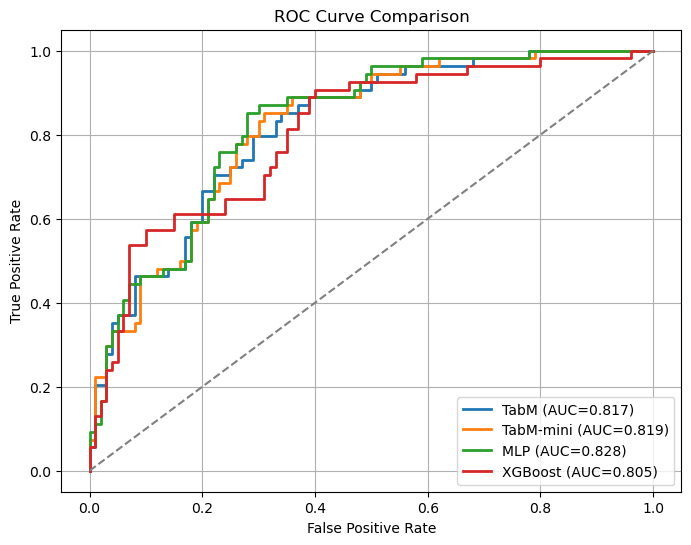

In [22]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

def plot_roc(y_true, probs, label):
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC={roc_auc:.3f})')

plot_roc(y_test, tabm_probs, 'TabM')
plot_roc(y_test, mini_probs, 'TabM-mini')
plot_roc(y_test, mlp_probs, 'MLP')
plot_roc(y_test, xgb_probs, 'XGBoost')


plt.plot([0, 1], [0, 1], '--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()



不调包

In [23]:
class TabMLayer(nn.Module):
    def __init__(self, input_dim, output_dim, num_models=8):
        super().__init__()
        self.num_models = num_models
        self.linear = nn.Linear(input_dim, output_dim, bias=False)
        self.r = nn.Parameter(torch.randn(num_models, input_dim))
        self.s = nn.Parameter(torch.randn(num_models, output_dim))
        self.b = nn.Parameter(torch.zeros(num_models, output_dim))

    def forward(self, x):
    
        outputs = []
        for i in range(self.num_models):
            x_mod = x * self.r[i]  
            out = self.linear(x_mod)  
            out = out * self.s[i] + self.b[i]  
            outputs.append(out)

        return torch.stack(outputs).mean(dim=0)


In [24]:
class TabMModel(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, output_dim=2, num_models=8):
        super().__init__()
        self.layer1 = TabMLayer(input_dim, hidden_dim, num_models)
        self.relu = nn.ReLU()
        self.layer2 = TabMLayer(hidden_dim, output_dim, num_models)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x


In [25]:
class TabMminiModel(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, output_dim=2, num_models=8):
        super().__init__()
        self.layer1 = TabMLayer(input_dim, hidden_dim, num_models)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x


In [26]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, output_dim=2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)


In [27]:
def train_model(model, loader, epochs=30):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in loader:
            preds = model(X_batch)
            loss = criterion(preds, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.4f}")


In [28]:

tabm_model = TabMModel()
tabm_mini_model = TabMminiModel()
mlp_model = SimpleMLP()

# TabM 
print("Training TabM:")
train_model(tabm_model, train_loader)

# TabM-mini
print("\nTraining TabM-mini:")
train_model(tabm_mini_model, train_loader)

# MLP 
print("\nTraining MLP:")
train_model(mlp_model, train_loader)

# XGBoost 
print("\nTraining XGBoost:")
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)


Training TabM:
Epoch [1/30] - Loss: 13.8473
Epoch [2/30] - Loss: 13.5153
Epoch [3/30] - Loss: 13.1339
Epoch [4/30] - Loss: 12.6775
Epoch [5/30] - Loss: 12.1372
Epoch [6/30] - Loss: 11.3468
Epoch [7/30] - Loss: 10.9390
Epoch [8/30] - Loss: 10.2373
Epoch [9/30] - Loss: 9.9650
Epoch [10/30] - Loss: 9.5824
Epoch [11/30] - Loss: 9.4527
Epoch [12/30] - Loss: 9.4480
Epoch [13/30] - Loss: 9.5272
Epoch [14/30] - Loss: 9.0328
Epoch [15/30] - Loss: 9.1872
Epoch [16/30] - Loss: 9.2240
Epoch [17/30] - Loss: 9.2996
Epoch [18/30] - Loss: 8.9681
Epoch [19/30] - Loss: 9.2833
Epoch [20/30] - Loss: 8.9088
Epoch [21/30] - Loss: 9.1585
Epoch [22/30] - Loss: 9.1119
Epoch [23/30] - Loss: 9.2848
Epoch [24/30] - Loss: 8.6628
Epoch [25/30] - Loss: 9.0356
Epoch [26/30] - Loss: 9.0692
Epoch [27/30] - Loss: 8.9144
Epoch [28/30] - Loss: 8.7321
Epoch [29/30] - Loss: 8.8276
Epoch [30/30] - Loss: 9.0092

Training TabM-mini:
Epoch [1/30] - Loss: 12.9794
Epoch [2/30] - Loss: 12.2877
Epoch [3/30] - Loss: 11.7334
Epoch [4

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [29]:
def evaluate_model(model, loader):
    model.eval()
    preds_list, true_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            preds = model(X_batch)
            probs = torch.softmax(preds, dim=1)[:, 1]
            preds_list.extend(probs.numpy())
            true_labels.extend(y_batch.numpy())
    accuracy = accuracy_score(true_labels, np.array(preds_list) > 0.5)
    auc = roc_auc_score(true_labels, preds_list)
    return accuracy, auc


In [30]:
# TabM
tabm_acc, tabm_auc = evaluate_model(tabm_model, test_loader)
print(f'TabM Accuracy: {tabm_acc:.4f}, AUC: {tabm_auc:.4f}')

# TabM-mini
mini_acc, mini_auc = evaluate_model(tabm_mini_model, test_loader)
print(f'TabM-mini Accuracy: {mini_acc:.4f}, AUC: {mini_auc:.4f}')

# MLP
mlp_acc, mlp_auc = evaluate_model(mlp_model, test_loader)
print(f'MLP Accuracy: {mlp_acc:.4f}, AUC: {mlp_auc:.4f}')

# XGBoost
xgb_preds = xgb_model.predict_proba(X_test)[:,1]
xgb_acc = accuracy_score(y_test, xgb_preds > 0.5)
xgb_auc = roc_auc_score(y_test, xgb_preds)
print(f'XGBoost Accuracy: {xgb_acc:.4f}, AUC: {xgb_auc:.4f}')


TabM Accuracy: 0.7273, AUC: 0.8224
TabM-mini Accuracy: 0.7273, AUC: 0.8291
MLP Accuracy: 0.7468, AUC: 0.8248
XGBoost Accuracy: 0.7338, AUC: 0.8052
